# Improve machine learning predictions with Neo4j Graph Data Science library
## Utilize graph algorithms in Neo4j to extract graph-based features to improve the accuracy of machine learning models

A wave of graph-based approaches to data science and machine learning is rising. We live in an era where the exponential growth of graph technology is predicted. The ability to analyze data points through the context of their relationships enables more profound and accurate data exploration and predictions. To help you catch the rising wave of graph machine learning, I have prepared a simple demonstration where I show how using graph-based features can increase the accuracy of a machine learning model.
We will be using an anonymized dataset from a P2P payment platform throughout this blog post.

The users are in the center of the graph. Throughout their stay on the P2P platform, they could have used multiple credit cards and various devices from multiple IPs. The main feature of the P2P payment platform is that users can send money to other users. Every transaction between users is represented as the P2P relationship, where the date and the amount is described. There could be multiple transactions between a single pair of users going in both directions.

Some of the users are labeled as fraud risks. Therefore, we can use the fraud risk label to train a supervised classification model to perform fraud detection. In this blog post, we will first use non-graphy features to train the classification model and then, in the second part, try to improve the model's accuracy by including some graph-based features like the PageRank centrality.

### Prepare the Neo4j environment

We will be using Neo4j as the source of truth to train the ML model. Therefore, I suggest you download and install the [Neo4j Desktop application](https://neo4j.com/download/) if you want to follow along with the code examples.
The dataset is available as a database dump. It is a variation of the database dump available on Neo4j's [product example GitHub to showcase fraud detection](https://github.com/neo4j-product-examples/demo-fraud-detection-with-p2p). I have added the fraud risk labels as described in the [second part of the Exploring fraud detection series](https://neo4j.com/developer-blog/exploring-fraud-detection-neo4j-graph-data-science-part-2/), so you don't have to deal with it. You can download the updated database dump by clicking on [this link](https://drive.google.com/file/d/1_N_QLtCRI-eeLzjEIFZAbj8YQrWfTolI/view?usp=sharing).
I've written a [post about restoring a database dump in Neo4j Desktop](https://tbgraph.wordpress.com/2020/11/11/dump-and-load-a-database-in-neo4j-desktop/) sometime ago if you need some help. After you have restored the database dump, you will also need to install the Graph Data Science and APOC libraries. Make sure you are using version 2.0.0 of the GDS or later.

### Neo4j Graph Data Science Python client
Neo4j team released an official Python client for the Graph Data Science library alongside the recent upgrade of the library to version 2.0. Since this is the first time I will be using the Python client for GDS in my blog, I will dedicate a bit more time to it and explain how it works.
First, you need to install the library. You can simply run the following command to install the latest deployed version of the GDS Python client.
```
pip install graphdatascience
```
Once you have installed the library, you need to input the Neo4j's credentials to define a connection to the database.

In [1]:
from graphdatascience import GraphDataScience

host = "bolt://localhost:7687"
user = "neo4j"
password= "password"

gds = GraphDataScience(host, auth=(user, password))

print(gds.version())

2.0.3


In the example I've seen, the first thing one usually does is to execute the print(gds.version()) line to verify that the connection is valid and the target database has the Graph Data Science library installed.
### Exploring the dataset
We will begin with simple data exploration. First, we will count the number of transactions by year from the database using the run_cypher method. The run_cypher method allows you to execute Cypher statements to retrieve data from the database and return a Pandas dataframe.

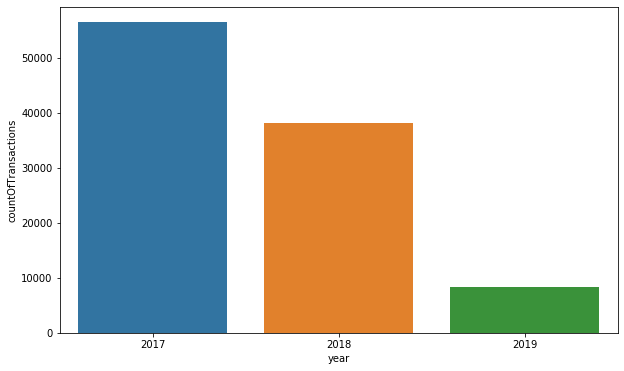

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
import seaborn as sns

time = gds.run_cypher("""
MATCH p=()-[r:P2P]->()
RETURN r.transactionDateTime.year AS year, count(*) AS countOfTransactions
ORDER BY year
""")

sns.barplot(x="year", y="countOfTransactions", data=time)

There were more than 50 thousand transactions in 2017, with a slight drop to slightly less than 40 transactions in 2018. I would venture a guess that we don't have all the transactions from 2019 as there are only 10 thousand transactions available in the dataset.

Our baseline classification model will contain only non-graph-based features. Therefore, we will begin by exploring various features like the number of devices, credit cards, and total and average incoming and outgoing amounts per user. We will stay clear of using the graph algorithm available in the Neo4j Graph Data Science library for now.

In [3]:
df = gds.run_cypher("""
MATCH (u:User)
CALL { 
  WITH u 
  MATCH (u)-[out:P2P]->() 
  RETURN sum(out.totalAmount) as totalOutgoingAmount, max(out.totalAmount) as maxOutgoingAmount, 
           avg(out.totalAmount) as avgOutgoingAmount, count(out) as outgoingTransactions
}
CALL { 
  WITH u 
  MATCH (u)<-[in:P2P]-() 
  RETURN sum(in.totalAmount) as totalIncomingAmount, max(in.totalAmount) as maxIncomingAmount, 
           avg(in.totalAmount) as avgIncomingAmount, count(in) as incomingTransactions
}
     
RETURN u.guid AS user_id,
       u.fraudRisk AS fraudRisk,
       size((u)-[:USED]->()) AS numberOfDevices,
       size((u)-[:HAS_CC]->()) AS numberOfCCs,
       size((u)-[:HAS_IP]->()) AS numberOfIps,
       coalesce(totalOutgoingAmount, 0) AS totalOutgoingAmount, 
       coalesce(avgOutgoingAmount, 0) AS avgOutgoingAmount,
       coalesce(maxOutgoingAmount, 0) AS maxOutgoingAmount,
       outgoingTransactions,
       coalesce(totalIncomingAmount, 0) AS totalIncomingAmount,
       coalesce(avgIncomingAmount, 0) AS avgIncomingAmount,
       coalesce(maxIncomingAmount, 0) AS maxIncomingAmount,
       incomingTransactions
""")

In [4]:
df.head()

,user_id,fraudRisk,numberOfDevices,numberOfCCs,numberOfIps,totalOutgoingAmount,avgOutgoingAmount,maxOutgoingAmount,outgoingTransactions,totalIncomingAmount,avgIncomingAmount,maxIncomingAmount,incomingTransactions
0,6f5ff01e3c3d9213b330c1a36e4e0d56,0,1,5,73,2272.0,98.782609,300.0,23,1000.00,83.333333,170.00,12
1,42489b0de3619b7558c170791fda29c3,0,1,8,88,100.0,100.000000,100.0,1,100.00,100.000000,100.00,1
2,227146a1ca295356b58e812e00490df5,0,1,13,171,206.0,206.000000,206.0,1,206.00,206.000000,206.00,1
3,665c3c081e8993803548d971b4e1814b,0,1,2,6,122.0,122.000000,122.0,1,167.22,83.610000,117.22,2
4,fda32eea75f7aab6b81f0654dd2120d0,0,1,7,39,0.0,0.000000,0.0,0,210.00,105.000000,200.00,2


We have counted the number of relationships a user has along with some basic statistics around the incoming and outgoing amounts. First, we will evaluate how many users are labeled as fraud risks. Remember, since the run_cypher method returns a Pandas Dataframe, you can utilize all the typical Pandas Dataframe methods.

In [5]:
df.groupby('fraudRisk').size().reset_index()

,fraudRisk,0
0,0,33521
1,1,211


As is typical with the fraud detection scenario, the dataset is heavily imbalanced. One could say that we are searching for a needle in a haystack. Next, we will use the Pandas `describe` method to evaluate value distributions.

In [6]:
df.describe()

,fraudRisk,numberOfDevices,numberOfCCs,numberOfIps,totalOutgoingAmount,avgOutgoingAmount,maxOutgoingAmount,outgoingTransactions,totalIncomingAmount,avgIncomingAmount,maxIncomingAmount,incomingTransactions
count,33732.000000,33732.000000,33732.000000,33732.000000,3.373200e+04,33732.000000,33732.000000,33732.000000,33732.000000,33732.000000,33732.000000,33732.000000
mean,0.006255,1.631270,3.796573,44.140549,1.076764e+03,125.803403,216.387065,3.048500,1076.764243,140.392911,233.734348,3.048500
std,0.078843,1.663217,4.549674,60.580664,1.155846e+04,393.291299,673.616348,15.062772,10055.629996,401.208172,683.305918,11.584737
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,8.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,5.000000,5.000000,1.000000
50%,0.000000,1.000000,3.000000,22.000000,5.000000e+00,5.000000,5.000000,1.000000,15.000000,10.000000,10.000000,1.000000
75%,0.000000,2.000000,5.000000,55.000000,1.540000e+02,97.500000,120.712500,2.000000,184.000000,103.850000,149.000000,2.000000
max,1.000000,65.000000,418.000000,849.000000,1.065990e+06,6250.000000,6750.000000,1073.000000,498911.090000,6250.000000,6750.000000,564.000000


Users have, on average used 1.6 devices on the platform, with one outlier having used 65 devices. What's a bit surprising is that the average number of credit cards used is almost 4. While I think that perhaps the high average of credit cards could be attributed to credit cards expiring, and therefore a user needs to add more than one credit card. However, it's still a higher average than I would expect. Both the total incoming and outgoing average amounts are around 1000, so we are not dealing with many high-value transactions. In addition, the median outgoing payment is only 5, while the incoming median amount is 15. Of course, there are some outliers as always, as one user has send a bit more than a million through the platform.

Before we move on to training the classification model, we will also evaluate the correlation between features.

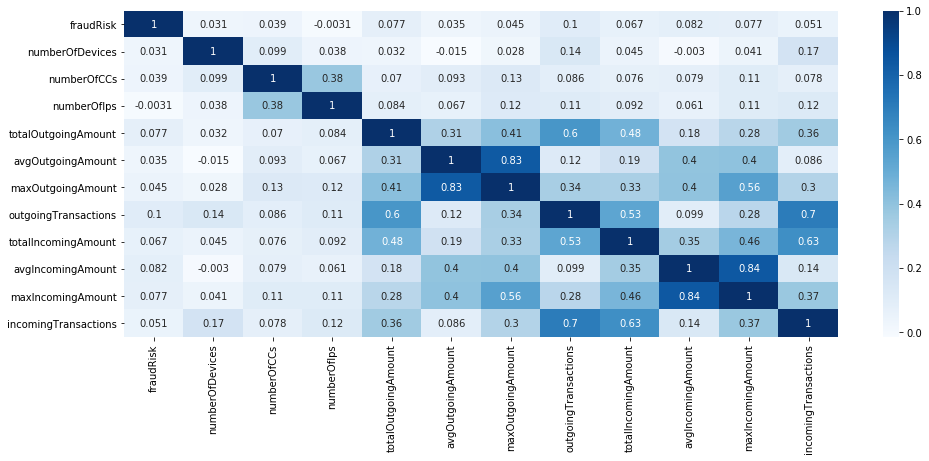

In [7]:
plt.figure(figsize=(16, 6))

corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="Blues",
            annot=True)

In [29]:
!pip install sklearn

It seems that none of the features correlate with the fraud risk label. As one would imagine, the number of transactions correlates with the total amount sent or received. The only other thing that I find interesting is that the number of credit cards correlates with the number of IPs.
# Training a baseline classification model
Now it's time to train a baseline classification model based on the non-graph-based features we pulled from the database. As part of the fraud detection use case, we will try to predict the fraud risk label. Since the dataset is heavily imbalanced, we will use an oversampling technique SMOTE on the training data. We will use Random Forest Classifier to keep things simple as the scope of this post is not to select the best ML model and/or their hyper-parameters.

I've prepared a function that will help us evaluate the model by visualizing the confusion matrix and the ROC curve.

In [9]:
import pandas as pd
# impory
# import sklearn.neighbors._base
# sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier

In [10]:
def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

def evaluate(df):
    df_X = df.drop('fraudRisk', axis=1)
    df_y = df[['fraudRisk']]

    X = df_X.values
    y = df_y.values

    y = LabelBinarizer().fit_transform(y)
    
    # Test/train data split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)
    
    # Oversample only the training data
    oversample = SMOTE(random_state=42)
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Random forrest classification
    model = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=5, bootstrap=True, class_weight='balanced')
    model = model.fit(X_train, y_train)
    # Evaluate the model
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize= 'true')
    RocCurveDisplay.from_estimator(model, X_test, y_test, name="RF Model")
    print(feature_importance(df_X.columns.to_list(), model))

Now that we have the data and the code ready, we can go ahead and train the baseline classification model.

                 feature     value
0        numberOfDevices  0.360835
1   incomingTransactions  0.193416
2      maxIncomingAmount  0.106009
3    totalIncomingAmount  0.074445
4            numberOfCCs  0.072848
5      avgIncomingAmount  0.068528
6      maxOutgoingAmount  0.025771
7      avgOutgoingAmount  0.025304
8    totalOutgoingAmount  0.025192
9            numberOfIps  0.024789
10  outgoingTransactions  0.022863


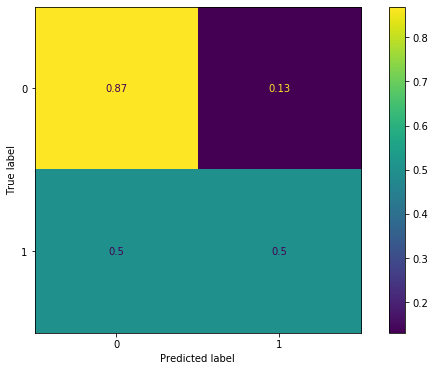

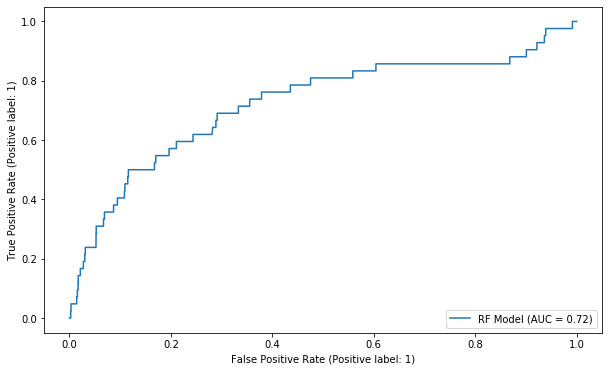

In [11]:
final_df = df[['fraudRisk', 'numberOfDevices', 'numberOfCCs', 'numberOfIps', 
               'totalOutgoingAmount','maxOutgoingAmount', 'avgOutgoingAmount',
               'totalIncomingAmount', 'maxIncomingAmount', 'avgIncomingAmount',
               'outgoingTransactions','incomingTransactions']]

evaluate(final_df)

The baseline model features performed reasonably. As a result, it correctly assigned a fraud risk label to 50% of the actual fraud risks while misclassifying the other half. Around 13% are non-frauds are wrongly classified as frauds. Remember that is quite a considerable number since the heavy data imbalance.

The AUC score of the baseline model is 0.72. The higher the AUC score, the better the model can distinguish between positive and negative labels. Lastly, we will look at the feature importance of the model.
Interestingly, the most important feature is the number of devices. Not really what one would expect. I would instead think that number of credit cards would have a higher impact. The following three important features are all tied to the count and the amount of the incoming transactions.
### Using graph-based features to increase the accuracy of the model
In the second part of the post, we will use graph-based features to increase the performance of the classification model. Lately, graph neural networks and various node embedding models are gaining popularity. However, we will keep it simple in this post and not use any of the more complex graph algorithms. Instead, we will use more classical centrality and community detection algorithms to produce features that will increase the accuracy of the classification model.

We have a couple of networks in our dataset. First, there is a direct P2P transaction network between users that we can use to extract features that describe users. On the other hand, there are also indirect connections between users, where some users use the same device, IP, or credit card.

In our example, we will use the P2P transaction network between users and indirect connections between users who share credit cards as the input to graph algorithms to extract predictive features.
Before executing any graph algorithms, we have to project the GDS in-memory graph. We will be using the newly released Graph Data Science Python client to project an in-memory graph. The Python client mimics the GDS Cypher procedure and follows an almost identical syntax. It seems to me the only difference is that we don't prefix the Cypher procedures with the `CALL` operator as we would when, for example, executing graph algorithms in Neo4j Browser.

We can use the following command to project User and Card nodes along with the HAS_CC and P2P relationships.

In [12]:
G, res = gds.graph.project('fraud', ['User', 'Card'], 
    {'HAS_CC':{
       'type':'HAS_CC'
    },
    'P2P':{
       'type':'P2P',
       'properties':{
          'totalAmount':{
             'aggregation':'SUM'
          }
       }
    }})

For those of you that have experience with GDS or read my previous blog post, the projection definition is, for the most part, straightforward. The only thing I haven't used in a while is that I have merged parallel P2P relationships into a single relationship during projection and summed their total amount. We merge parallel relationships and sum a specific property of the relationships using the following syntax:

```
'P2P':{       
    'type':'P2P',
    'properties':{      
        'totalAmount':{
             'aggregation':'SUM'          
         }       
     }    
}
```

With the projected in-memory graph ready, we can go ahead and execute intended graph algorithms.
### Weakly connected components
We will begin by using the Weakly Connected components (WCC) algorithm. The WCC algorithm is used to find disconnected components or islands within the network.

All nodes in a single weakly connected component can reach other nodes in the component when we disregard the direction of the relationship. In our example, we will use the WCC algorithm to find components or islands of users who used the same credit card.

We will use the `stream` mode of the WCC algorithm using the GDS Python client, which will return a Pandas Dataframe. Any additional configuration parameters can be added as keyword arguments.

In [17]:
# User - Card WCC
graph_features = gds.wcc.stream(G, nodeLabels=['User', 'Card'], relationshipTypes=['HAS_CC'])

In [14]:
G

Graph({'graphName': 'fraud', 'nodeCount': 152550, 'relationshipCount': 171201, 'database': 'neo4j', 'configuration': {'relationshipProjection': {'HAS_CC': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'HAS_CC', 'properties': {}}, 'P2P': {'orientation': 'NATURAL', 'aggregation': 'DEFAULT', 'type': 'P2P', 'properties': {'totalAmount': {'defaultValue': None, 'property': 'totalAmount', 'aggregation': 'SUM'}}}}, 'nodeProjection': {'User': {'label': 'User', 'properties': {}}, 'Card': {'label': 'Card', 'properties': {}}}, 'relationshipProperties': [], 'creationTime': neo4j.time.DateTime(2023, 1, 27, 13, 48, 59, 349199000, tzinfo=<DstTzInfo 'Asia/Kolkata' IST+5:30:00 STD>), 'validateRelationships': False, 'readConcurrency': 4, 'sudo': False, 'nodeProperties': [], 'username': None}, 'schema': {'relationships': {'HAS_CC': {}, 'P2P': {'totalAmount': 'Float (DefaultValue(NaN), PERSISTENT, Aggregation.SUM)'}}, 'nodes': {'User': {}, 'Card': {}}}, 'memoryUsage': '19 MiB'})

We have used the _nodeLabels_ parameter to specify which nodes the algorithm should consider as well as the _relationshipTypes_ parameter to define relationship types. Using the _relationshipTypes_ parameter, we have defined the algorithm to consider the *HAS_CC* relationships and ignore the *P2P* relationships.
As mentioned, the above statement returns a Pandas Dataframe that contains the internal node ids and the component ids.

In [15]:
graph_features.head()

,nodeId,componentId
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


The output of the WCC algorithm will contain both the User and the Card nodes. Since we are only interested in User nodes, we must first retrieve the node labels using the `gds.util.asNodes` method and then filter on the node label.

In [18]:
# Retrieve node objects from the database
graph_features['node_object'] = gds.util.asNodes(graph_features['nodeId'].to_list())


In [22]:
graph_features["node_object"].head()

0    (fraudRisk, guid, fraudMoneyTransfer, wccId, m...
1    (fraudRisk, guid, fraudMoneyTransfer, wccId, m...
2    (fraudRisk, guid, fraudMoneyTransfer, wccId, m...
3    (fraudRisk, guid, fraudMoneyTransfer, wccId, m...
4    (fraudRisk, guid, fraudMoneyTransfer, wccId, m...
Name: node_object, dtype: object

In [23]:
# Filter only user nodes
graph_features = graph_features[[list(x.labels)[0] == 'User' for x in graph_features['node_object']]]

In [26]:
for x in graph_features['node_object'].head():
    print(x.labels)

frozenset({'User'})
frozenset({'User'})
frozenset({'User'})
frozenset({'User'})
frozenset({'User'})


In [28]:
# Get component sizes
graph_features = graph_features.merge(
    graph_features.groupby('componentId').size().to_frame('componentSize').reset_index(), on="componentId")
graph_features.head()

,nodeId,componentId,node_object,componentSize
0,0,0,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2
1,7419,0,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2
2,1,1,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",1
3,2,2,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2
4,6343,2,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2


Lastly, we will define two features based on the WCC algorithm results. The *componentSize* feature will contain a value of the users in the component, while the *part_of_community* feature will indicate if the component has more than one member.

In [29]:

# Define a feature which indicates if the component has more than 1 member
graph_features['part_of_community'] = (graph_features['componentSize'] > 1).astype(int)

# PageRank centrality
Next, we will use the PageRank centrality of the P2P transaction network as one of our features. PageRank algorithm is commonly used to find the most important or influential nodes in the network. The algorithm considers every relationship as a vote of confidence or importance, and then the nodes deemed the most important by other important nodes rank the highest. Unlike the degree centrality, which only considers the number of incoming relationships, the PageRank algorithm also considers the importance of nodes pointing to it. A simple example is that being a friend with the president of the country or a company gives you more influence than being friends with an intern. Unless that intern happens to be a family relative to the CEO.

You can execute the `stream` mode of the weighted variant of the PageRank algorithm using the following Python code.

In [30]:
# Pagerank centrality
pr = gds.pageRank.stream(G, nodeLabels=['User'], 
    relationshipTypes=['P2P'], relationshipWeightProperty='totalAmount')


In [31]:
# pr['pagerank'] = pr['score']
# graph_features = graph_features.merge(pr[['nodeId', 'pagerank']], on='nodeId')
pr['score'].head()

0    0.680221
1    1.073887
2    0.961240
3    0.197473
4    0.277943
Name: score, dtype: float64

In [35]:
pr.head()

,nodeId,score
0,0,0.680221
1,1,1.073887
2,2,0.961240
3,3,0.197473
4,4,0.277943


In [36]:
pr['pagerank'] = pr['score']
graph_features = graph_features.merge(pr[['nodeId', 'pagerank']], on='nodeId')

In [37]:
graph_features.head()

,nodeId,componentId,node_object,componentSize,part_of_community,pagerank
0,0,0,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2,1,0.680221
1,7419,0,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2,1,0.337819
2,1,1,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",1,0,1.073887
3,2,2,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2,1,0.961240
4,6343,2,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2,1,0.961240


This code first executes the stream mode of the PageRank algorithm, which returns the results in the form of the Pandas Dataframe. Using the *nodeLabels* parameter, we specify that the algorithm should only consider User nodes. Additionally, we use the relationshipTypes parameter to use only the *P2P* relationships as input. Lastly, we merge the new pagerank score column to the graph_features dataframe.
# Closeness centrality
The last feature we will use is the Closeness centrality. The Closeness centrality algorithm evaluates how close a node is to all the other nodes in the network. Essentially, the algorithm results inform us which nodes can reach all the other nodes in the network the fastest.

The syntax to execute the Closeness centrality and merge the results to the graph_features data frame is almost identical as the PageRank example.

In [38]:
# Closeness centrality
bc = gds.beta.closeness.stream(G, nodeLabels=['User'], relationshipTypes=['P2P'])
bc['closeness'] = bc['score']
graph_features = graph_features.merge(bc[['nodeId', 'closeness']], on='nodeId')


In [39]:
graph_features.head()

,nodeId,componentId,node_object,componentSize,part_of_community,pagerank,closeness
0,0,0,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2,1,0.680221,0.163444
1,7419,0,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2,1,0.337819,0.151806
2,1,1,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",1,0,1.073887,0.075315
3,2,2,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2,1,0.961240,1.000000
4,6343,2,"(fraudRisk, guid, fraudMoneyTransfer, wccId, m...",2,1,0.961240,1.000000


In [41]:
[el.get('guid') for el in graph_features['node_object'].head()]

['6f5ff01e3c3d9213b330c1a36e4e0d56',
 '1e84798cac010c18f058c41d103f2076',
 '42489b0de3619b7558c170791fda29c3',
 '227146a1ca295356b58e812e00490df5',
 'ad9203327f289fa513763a4760914e0c']

### Combine baseline and graph features
Before we can train the new classification model, we have to combine the original dataframe that contains the baseline features with the graph_feature dataframe that includes the graph-based features.

In [42]:
# Get user ids
graph_features['user_id'] = [el.get('guid') for el in graph_features['node_object']]
# Merge to original df
df = df.merge(graph_features[['user_id', 'componentSize', 'part_of_community', 'pagerank', 'closeness']], on='user_id')

In [43]:
df.head()

,user_id,fraudRisk,numberOfDevices,numberOfCCs,numberOfIps,totalOutgoingAmount,avgOutgoingAmount,maxOutgoingAmount,outgoingTransactions,totalIncomingAmount,avgIncomingAmount,maxIncomingAmount,incomingTransactions,componentSize,part_of_community,pagerank,closeness
0,6f5ff01e3c3d9213b330c1a36e4e0d56,0,1,5,73,2272.0,98.782609,300.0,23,1000.00,83.333333,170.00,12,2,1,0.680221,0.163444
1,42489b0de3619b7558c170791fda29c3,0,1,8,88,100.0,100.000000,100.0,1,100.00,100.000000,100.00,1,1,0,1.073887,0.075315
2,227146a1ca295356b58e812e00490df5,0,1,13,171,206.0,206.000000,206.0,1,206.00,206.000000,206.00,1,2,1,0.961240,1.000000
3,665c3c081e8993803548d971b4e1814b,0,1,2,6,122.0,122.000000,122.0,1,167.22,83.610000,117.22,2,2,1,0.197473,0.137684
4,fda32eea75f7aab6b81f0654dd2120d0,0,1,7,39,0.0,0.000000,0.0,0,210.00,105.000000,200.00,2,1,0,0.277943,0.171180


The original dataframe does not contain the internal node ids, so we must first extract the user ids from the node object column. Next, we can use the user id column to merge the baseline and the graph-based feature dataframes.
### Include the graph-based features in the classification model
Now we can go ahead and include both the baseline as well as the graph-based features to train the fraud detection classification model.

                 feature     value
0          componentSize  0.371820
1      part_of_community  0.301243
2        numberOfDevices  0.105482
3   incomingTransactions  0.060731
4    totalIncomingAmount  0.028057
5      maxIncomingAmount  0.027178
6              closeness  0.026716
7      avgIncomingAmount  0.022201
8            numberOfCCs  0.013917
9               pagerank  0.010389
10           numberOfIps  0.009248
11  outgoingTransactions  0.005958
12     avgOutgoingAmount  0.005938
13     maxOutgoingAmount  0.005899
14   totalOutgoingAmount  0.005224


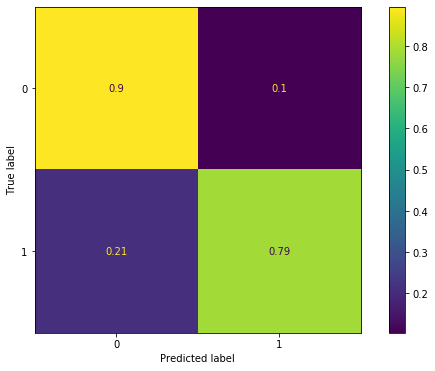

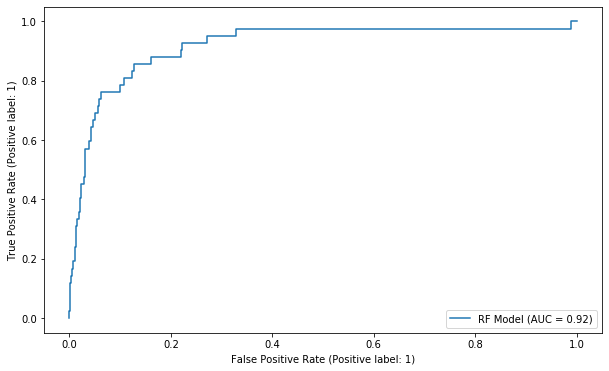

In [44]:
final_df = df[['fraudRisk','numberOfDevices', 'numberOfCCs', 'numberOfIps', 
               'totalOutgoingAmount','maxOutgoingAmount', 'avgOutgoingAmount',
               'totalIncomingAmount', 'maxIncomingAmount', 'avgIncomingAmount',
               'outgoingTransactions','incomingTransactions', 'componentSize', 'part_of_community', 
               'pagerank', 'closeness']]

evaluate(final_df)

We can observe that the model correctly classified 79% of fraudsters instead of 50% with the baseline model. However, it also misclassifies fewer non-frauds as frauds. We can observe that the graph-based features helped improve the classification model accuracy. We can also observe that the AUC score has risen from 0.72 to 0.92, which is a considerable increase. Finally, let's evaluate the importance of the graph-based features. While the number of credit cards used by a user might be significant to classify the fraudsters accurately, a far more predictive feature in this dataset is if multiple users and how many used those credit cards. The PageRank and Closeness centrality also added a slight increase in the accuracy, although they are less predictive in this example than the weakly component size

In [45]:
# Drop the projected graph
G.drop()

graphName                                                        fraud
database                                                         neo4j
memoryUsage                                                           
sizeInBytes                                                         -1
nodeCount                                                       152550
relationshipCount                                               171201
configuration        {'relationshipProjection': {'HAS_CC': {'orient...
density                                                       0.000007
creationTime                       2023-01-27T13:48:59.349199000+05:30
modificationTime                   2023-01-27T13:49:02.415219000+05:30
schema               {'relationships': {'HAS_CC': {}, 'P2P': {'tota...
Name: 0, dtype: object